In [114]:
# preprocessing images

import os, random, cv2
import numpy as np
import imutils.paths as paths
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torch import nn
import torch.optim as optim
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import accuracy_score


In [2]:
%config Completer.use_jedi = False



In [2]:
num_images = 1200

In [3]:
dir_paths = os.listdir('./Train')
dir_paths.sort()
print(dir_paths)

root_path = './Train'

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:



# for idx, dir_path in tqdm(enumerate(dir_paths), total=len(dir_paths)):
#     all_images = os.listdir(f'{root_path}/{dir_path}')
#     os.makedirs(f"./preprocessed_image/{dir_path}", exist_ok=True)
#     for i in range(num_images):
#         rand_id = random.randint(0, 2999)
#         image = cv2.imread(f'{root_path}/{dir_path}/{all_images[rand_id]}')
#         image = cv2.resize(image, (244, 244))
#         cv2.imwrite(f"./preprocessed_image/{dir_path}/{dir_path}{i}.jpg", image)

In [6]:
# building data.csv containing image_paths and its labels

image_paths = list(paths.list_images('./Train'))
# print(image_paths)
data = pd.DataFrame()

labels = []

for i, image_path in tqdm(enumerate(image_paths), total =len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    
    labels.append(label)

labels = np.array(labels)

from sklearn.preprocessing import LabelBinarizer


# Mapping the first one hot encoded label to its category
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)

data = data.sample(frac=1).reset_index(drop=True)
# data.to_csv('../input/data.csv', index=False)



    

100%|██████████| 87000/87000 [03:31<00:00, 410.88it/s] 


In [7]:
data.head()

,image_path,target
0,./Train/del/del177.jpg,26.0
1,./Train/F/F2709.jpg,5.0
2,./Train/I/I390.jpg,8.0
3,./Train/A/A2904.jpg,0.0
4,./Train/X/X2.jpg,23.0


In [8]:
data.target.nunique()

29

In [9]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



train_set, test_set = train_test_split(data, test_size=0.2,random_state=42)
train_set.to_csv('./train_set.csv', index=False)
test_set.to_csv('./test_set.csv', index=False)

In [10]:
df_train = pd.DataFrame(train_set.target.value_counts()).reset_index()
df_train.columns = ['Class', 'Samples']
# df_train.Samples = (df_train.Samples - df_train.Samples.min()) / (df_train.Samples.max() - df_train.Samples.min())
df_train.head()

,Class,Samples
0,19.0,2440
1,22.0,2439
2,8.0,2427
3,16.0,2424
4,12.0,2424


### Plot of distribution(train and test)

/home/nayugartx8/Desktop/Aayush_work/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='Samples'>

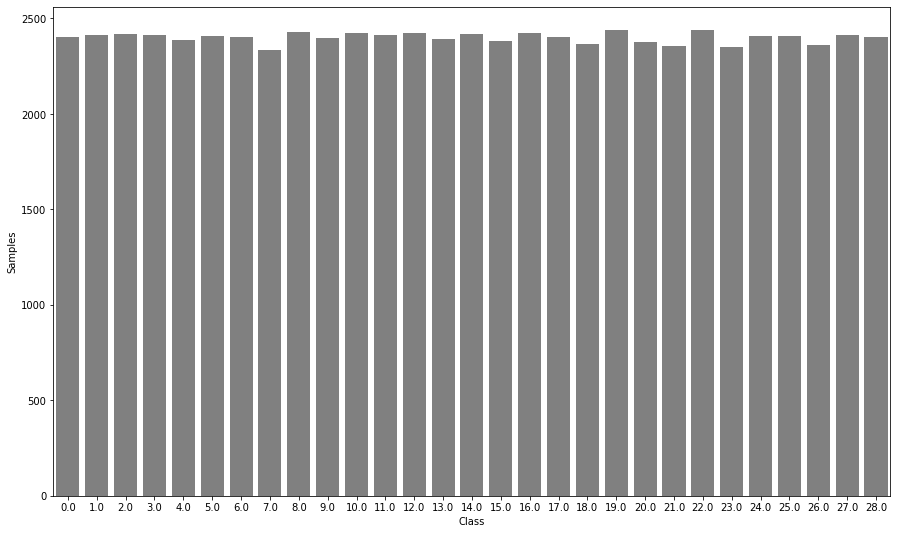

In [11]:
import seaborn as sns

plt.figure(figsize=(15, 9))
sns.barplot(df_train.Class, df_train.Samples, color='gray')



In [12]:
df_test = pd.DataFrame(test_set.target.value_counts()).reset_index()
df_test.columns = ['Class', 'Samples']
# df_test.Samples = (df_test.Samples - df_test.Samples.min()) / (df_test.Samples.max() - df_test.Samples.min())
df_test.head()

,Class,Samples
0,7.0,668
1,23.0,648
2,21.0,646
3,26.0,637
4,18.0,634


/home/nayugartx8/Desktop/Aayush_work/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='Samples'>

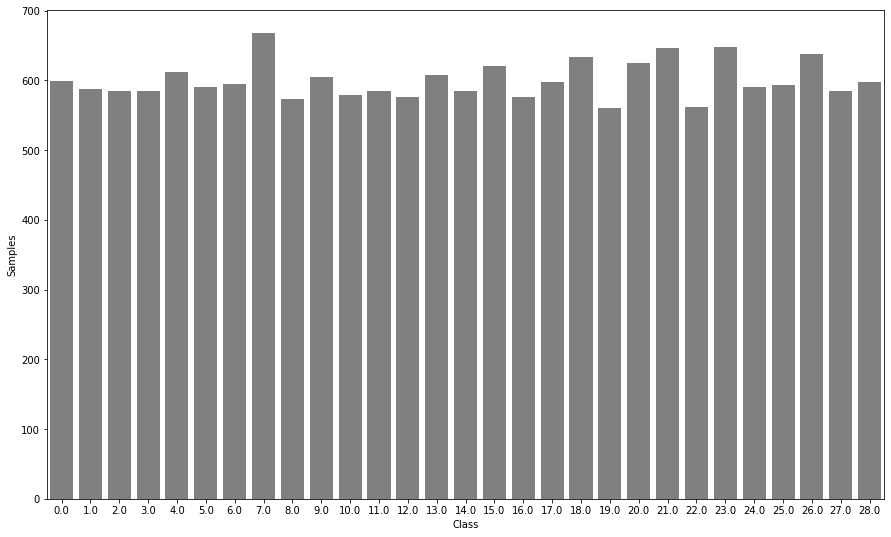

In [13]:
plt.figure(figsize=(15, 9))
sns.barplot(df_test.Class, df_test.Samples, color='gray')

In [14]:
data.to_csv('./data.csv', index=False)

In [16]:
len(data)

87000

In [17]:
class ASL_dataset(Dataset):
    
    def __init__(self, csv_path, train=True):

        self.csv_file = pd.read_csv(csv_path)
        self.train = train
        if self.train:
            self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        image_name = os.path.join(self.csv_file.iloc[idx, 0])
#         print(image_name)
        image = Image.open(image_name)
        
        labels = np.array(self.csv_file.iloc[idx, 1:]).astype(np.float32)
#         print(labels)
        sample = {'image': image, 'labels': labels }
        sample['image'] = self.transform(sample['image'])
        sample['labels'] = torch.tensor(int(sample['labels'])).long()
        return sample
            
        


### Plot some random samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1132, 1810])


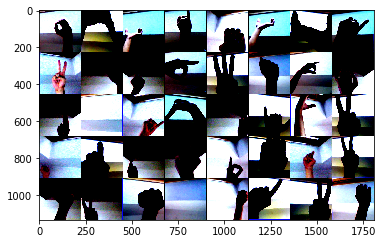

In [46]:
asl_dataset = ASL_dataset(csv_path='./test_set.csv')
# print(len(asl_dataset))
import matplotlib.pyplot as plt
x_train = []
for i in range(0,400,10):
    sample = asl_dataset[i]
    x_train.append(sample['image'])

# make a grid of 40 images, 8 images per row
x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)
# call helper function
show(x_grid)

###  Model Creation

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [20]:
# Defining model



class SignLanguageClassifier(nn.Module):
    
    def __init__(self):
        super(SignLanguageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 3)
        
        self.fc1 = nn.Linear(128, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64,len(lb.classes_))
        
        self.drop = nn.Dropout(0.25)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool(nn.functional.relu(x))
        
    
        # conv2
        x =self.conv2(x)
        x = self.bn2(x)
        x = self.pool(nn.functional.relu(x))
        #conv3
        x = self.bn3(self.conv3(x))
        x = self.pool(nn.functional.relu(x))
        #conv4 
        x = self.bn4(self.conv4(x))
        x = self.pool(nn.functional.relu(x))
        
        #fully connected layers
        batch_size, _, _, _ = x.shape
        
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        x = self.drop(nn.functional.relu(self.fc1(x)))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

### Training Code

####  Checkpoint file paths

In [27]:
checkpoint_file_path = './checkpoint.ckpt'
best_checkpoint = './best_checkpoint.ckpt'

In [21]:
# setting params
epochs = 100

# seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark=True

In [22]:
train_data = ASL_dataset('./train_set.csv')
test_data = ASL_dataset('./test_set.csv', train=False)

In [47]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [24]:
model = SignLanguageClassifier().to(device)
print(model)

SignLanguageClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=29, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [25]:
model.forward(torch.zeros((1, 3, 256, 256)).to(device))

tensor([[-0.0406,  0.0953, -0.0231, -0.0317,  0.1356,  0.0125, -0.0115,  0.0387,
         -0.0908, -0.0250, -0.1058,  0.0076,  0.0646,  0.0275, -0.1194, -0.0689,
         -0.0256,  0.0603, -0.1315,  0.1387,  0.1026,  0.0028, -0.0894, -0.0668,
         -0.0086, -0.1168, -0.0340, -0.1288,  0.1202]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [26]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
       BatchNorm2d-2         [-1, 16, 254, 254]              32
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 123, 123]          12,832
       BatchNorm2d-5         [-1, 32, 123, 123]              64
         MaxPool2d-6           [-1, 32, 61, 61]               0
            Conv2d-7           [-1, 64, 57, 57]          51,264
       BatchNorm2d-8           [-1, 64, 57, 57]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 26, 26]          73,856
      BatchNorm2d-11          [-1, 128, 26, 26]             256
        MaxPool2d-12          [-1, 128, 13, 13]               0
           Linear-13                   [-1, 96]          12,384
          Dropout-14                   

In [59]:
# Optimizer 
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [60]:
# define device as a global variable
device = torch.device("cuda")


In [50]:
# from torch.utils.tensorboard import SummaryWriter

In [49]:
# writer = SummaryWriter()

In [57]:
# defining lr scheduler 

from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(optimizer,T_max=2,eta_min=0.005)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

for i in range(10):
    lr_scheduler.step()
    print("epoch %s, lr: %.1e" %(i,get_lr(optimizer)))

epoch 0, lr: 3.0e-03
epoch 1, lr: 5.0e-03
epoch 2, lr: 3.0e-03
epoch 3, lr: 1.0e-03
epoch 4, lr: 3.0e-03
epoch 5, lr: 5.0e-03
epoch 6, lr: 3.0e-03
epoch 7, lr: 1.0e-03
epoch 8, lr: 3.0e-03
epoch 9, lr: 5.0e-03


In [152]:
#  count the number of correct predictions per data batch
from sklearn.metrics import accuracy_score

def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = (pred == target).sum().item()
    return corrects

In [130]:
# function to compute the loss value per batch of data:

def loss_batch(loss_func, output, target, optimizer=None):
    
    #get loss
    loss = loss_func(output, target)
    
#     get performance metric
    metric_b = metrics_batch(output, target)
    
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss.item(), metric_b


In [162]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0
    running_metric = 0
    len_data = len(dataset_dl.dataset)
    
    for data in dataset_dl:
        # move to gpu
        xb = data['image'].to(device)
        yb = data['labels'].to(device)
        
        #get model output
        output = model(xb)
        
        #get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        #update running loss and metric
        running_loss += loss_b
        

        if metric_b is not None:
            running_metric += metric_b
            
        #break loop isn case of sanity check
        if sanity_check is True:
            break
    
    # avg loss value
    loss = running_loss/float(len_data)
    
    #avg metric value
    metric = running_metric/float(len_data)
    
    return loss, metric
    
    
        
        
    

In [163]:
# defining training loop

def train(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
     # history of loss values in each epoch
    loss_history={
        "train": [],
        "test": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "test": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_loader,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on test dataset    
        model.eval()
        with torch.no_grad():
            test_loss, test_metric=loss_epoch(model,loss_func,test_loader,sanity_check)

        # store best model

        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)

       # learning rate schedule
        lr_scheduler.step()


        print("train loss: %.6f, test loss: %.6f, accuracy: %.2f" %(train_loss,test_loss,test_metric))
        print("-"*10)
    
    #load best model weights

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history  
    

## Train With Random-Init Weights¶

In [164]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(),lr=0.005)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=0.005)

In [ ]:
params_train={
 "num_epochs": 10,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_loader,
 "test_dl": test_loader,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "signlang.pt",
}

model_sign,loss_hist,metric_hist=train(model,params_train)

Epoch 0/9, current lr=0.005


In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-test Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["test"],label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-test Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["test"],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
torch.save(model, './Sign_Language_Classifier.pth')